## Importing data (Alex updated: 4/30/19)

In [1]:
import numpy as np

# Image processing tools
import skimage
import skimage.filters

import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from numpy.linalg import inv

from tqdm import tqdm, trange
from scipy import special, optimize
from scipy import integrate

import plotly.offline as py
import plotly.graph_objs as go
import plotly
#plotly.tools.set_credentials_file(username='AYChoi', api_key='ZacDa7fKo8hfiELPfs57')
plotly.tools.set_credentials_file(username='AlexanderYChoi', api_key='VyLt05wzc89iXwSC82FO')

Load the e-ph matrix elements data. The two numbers reported at the end should be the same. If they are not, there are duplicate e-ph elements. It's VERY IMPORTANT to note that the g elements here are actually |g|^2 which is why they are real numbers.

In [2]:
data = pd.read_csv('gaas.eph_matrix', sep='\t',header= None,skiprows=(0,1))
data.columns = ['0']
data_array = data['0'].values
new_array = np.zeros((len(data_array),7))
for i1 in trange(len(data_array)):
    new_array[i1,:] = data_array[i1].split()
    
g_df = pd.DataFrame(data=new_array,columns = ['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element'])
g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']] = g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']].apply(pd.to_numeric,downcast = 'integer')
len(g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element']]),len(g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element']].drop_duplicates())

100%|██████████| 7854608/7854608 [00:16<00:00, 467546.38it/s]


(7854608, 7854608)

Now load the k-point indices, q-point indices, k-point energies, phonon energies into dataframes.

In [3]:
kpts = pd.read_csv('gaas.kpts', sep='\t',header= None)
kpts.columns = ['0']
kpts_array = kpts['0'].values
new_kpt_array = np.zeros((len(kpts_array),4))
for i1 in trange(len(kpts_array)):
    new_kpt_array[i1,:] = kpts_array[i1].split()
    
kpts_df = pd.DataFrame(data=new_kpt_array,columns = ['k_inds','b1','b2','b3'])
kpts_df[['k_inds']] = kpts_df[['k_inds']].apply(pd.to_numeric,downcast = 'integer')
kpts_df.head()

100%|██████████| 2213/2213 [00:00<00:00, 626104.20it/s]


,k_inds,b1,b2,b3
0,1,0.0,0.0,0.00
1,2,0.0,0.0,0.01
2,3,0.0,0.0,0.02
3,4,0.0,0.0,0.03
4,5,0.0,0.0,0.04


In [4]:
enk = pd.read_csv('gaas.enk', sep='\t',header= None)
enk.columns = ['0']
enk_array = enk['0'].values
new_enk_array = np.zeros((len(enk_array),3))
for i1 in trange(len(enk_array)):
    new_enk_array[i1,:] = enk_array[i1].split()
    
enk_df = pd.DataFrame(data=new_enk_array,columns = ['k_inds','band_inds','energy [Ryd]'])
enk_df[['k_inds','band_inds']] = enk_df[['k_inds','band_inds']].apply(pd.to_numeric,downcast = 'integer')
enk_df.head()

100%|██████████| 2213/2213 [00:00<00:00, 492048.07it/s]


,k_inds,band_inds,energy [Ryd]
0,1,1,0.445788
1,2,1,0.447866
2,3,1,0.453308
3,4,1,0.460652
4,5,1,0.468793


In [5]:
enq = pd.read_csv('gaas.enq', sep='\t',header= None)
enq.columns = ['0']
enq_array = enq['0'].values
new_enq_array = np.zeros((len(enq_array),3))
for i1 in trange(len(enq_array)):
    new_enq_array[i1,:] = enq_array[i1].split()
    
enq_df = pd.DataFrame(data=new_enq_array,columns = ['q_inds','im_mode','energy [Ryd]'])
enq_df[['q_inds','im_mode']] = enq_df[['q_inds','im_mode']].apply(pd.to_numeric,downcast = 'integer')
print(enq_df.shape)
enq_df.head()

100%|██████████| 126480/126480 [00:00<00:00, 477268.66it/s]

(126480, 3)


,q_inds,im_mode,energy [Ryd]
0,1,1,0.000020
1,1,2,0.000026
2,1,3,0.000054
3,1,4,0.002432
4,1,5,0.002432


In [6]:
qpts = pd.read_csv('gaas.qpts', sep='\t',header= None)
qpts.columns = ['0']
qpts_array = qpts['0'].values
new_qpt_array = np.zeros((len(qpts_array),4))

for i1 in trange(len(qpts_array)):
    new_qpt_array[i1,:] = qpts_array[i1].split()
    
qpts_df = pd.DataFrame(data=new_qpt_array,columns = ['q_inds','b1','b2','b3'])
qpts_df[['q_inds']] = qpts_df[['q_inds']].apply(pd.to_numeric,downcast = 'integer')
print(qpts_df.shape)
qpts_df.head()

100%|██████████| 21080/21080 [00:00<00:00, 524026.98it/s]

(21080, 4)


,q_inds,b1,b2,b3
0,1,0.0,0.0,0.01
1,2,0.0,0.0,0.02
2,3,0.0,0.0,0.03
3,4,0.0,0.0,0.04
4,5,0.0,0.0,0.05


## Data Processing (Alex Updated: 4/30)

In [7]:
def cartesian_q_points(qpts_df):
    """
    Given a dataframe containing indexed q-points in terms of the crystal lattice vector, return the dataframe with cartesian q coordinates.     
    Parameters:
    -----------
    qpts_df : pandas dataframe containing:
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in momentum space [1/A]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in momentum space [1/A]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in momentum space [1/A]
        
    For FCC lattice, use the momentum space primitive vectors as per:
    http://lampx.tugraz.at/~hadley/ss1/bzones/fcc.php
    
    b1 = 2 pi/a (kx - ky + kz)
    b2 = 2 pi/a (kx + ky - kz)
    b3 = 2 pi/a (-kx + ky + kz)
    
    Returns:
    --------
    cart_kpts_df : pandas dataframe containing:
    
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]  
    """
    
    # Need a lattice constant for GaAs. This is obviously somewhat sensitive to temperature.
    a = 5.556 #[A]
    
    cartesian_df = pd.DataFrame(columns = ['q_inds','kx [1/A]','ky [1/A]','kz [1/A]'])
    
    con1 = pd.DataFrame(columns = ['kx [1/A]','ky [1/A]','kz [1/A]'])
    con1['kx [1/A]'] = np.ones(len(qpts_df))*-1
    con1['ky [1/A]'] = np.ones(len(qpts_df))*-1
    con1['kz [1/A]'] = np.ones(len(qpts_df))*1

    con2 = con1.copy(deep=True)
    con2['kx [1/A]'] = con2['kx [1/A]'].values*-1
    con2['ky [1/A]'] = con2['ky [1/A]'].values*-1

    con3 = con1.copy(deep=True)
    con3['ky [1/A]'] = con2['ky [1/A]'].values
    con3['kz [1/A]'] = con3['kz [1/A]'].values*-1
    
    
    cartesian_df['kx [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['kx [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['kx [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['kx [1/A]'].values))
    cartesian_df['ky [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['ky [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['ky [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['ky [1/A]'].values))
    cartesian_df['kz [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['kz [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['kz [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['kz [1/A]'].values))

    cartesian_df['q_inds'] = qpts_df['q_inds'].values
    
    cartesian_df_edit = cartesian_df.copy(deep=True)

    qx_plus = cartesian_df['kx [1/A]'] > 0.5
    qx_minus = cartesian_df['kx [1/A]'] < -0.5

    qy_plus = cartesian_df['ky [1/A]'] > 0.5
    qy_minus = cartesian_df['ky [1/A]'] < -0.5

    qz_plus = cartesian_df['kz [1/A]'] > 0.5
    qz_minus = cartesian_df['kz [1/A]'] < -0.5

    cartesian_df_edit.loc[qx_plus,'kx [1/A]'] = cartesian_df.loc[qx_plus,'kx [1/A]'] -1
    cartesian_df_edit.loc[qx_minus,'kx [1/A]'] = cartesian_df.loc[qx_minus,'kx [1/A]'] +1

    cartesian_df_edit.loc[qy_plus,'ky [1/A]'] = cartesian_df.loc[qy_plus,'ky [1/A]'] -1
    cartesian_df_edit.loc[qy_minus,'ky [1/A]'] = cartesian_df.loc[qy_minus,'ky [1/A]'] +1

    cartesian_df_edit.loc[qz_plus,'kz [1/A]'] = cartesian_df.loc[qz_plus,'kz [1/A]'] -1
    cartesian_df_edit.loc[qz_minus,'kz [1/A]'] = cartesian_df.loc[qz_minus,'kz [1/A]'] +1
    
    return cartesian_df,cartesian_df_edit

In [8]:
a = 5.556 #[A]
kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
T = 300
e = 1.602*10**(-19)

In [9]:
kvel = pd.read_csv('gaas.vel', sep='\t',header= None,skiprows=[0,1,2])
kvel.columns = ['0']
kvel_array = kvel['0'].values
new_kvel_array = np.zeros((len(kvel_array),10))
for i1 in trange(len(kvel_array)):
    new_kvel_array[i1,:] = kvel_array[i1].split()
    
kvel_df = pd.DataFrame(data=new_kvel_array,columns = ['k_inds','bands','energy','kx [2pi/alat]','ky [2pi/alat]','kz [2pi/alat]','vx_dir','vy_dir','vz_dir','v_mag [m/s]'])
kvel_df[['k_inds']] = kvel_df[['k_inds']].apply(pd.to_numeric,downcast = 'integer')

kvel_edit = kvel_df.copy(deep=True)

kx_plus = kvel_df['kx [2pi/alat]'] > 0.5
kx_minus = kvel_df['kx [2pi/alat]'] < -0.5

ky_plus = kvel_df['ky [2pi/alat]'] > 0.5
ky_minus = kvel_df['ky [2pi/alat]'] < -0.5

kz_plus = kvel_df['kz [2pi/alat]'] > 0.5
kz_minus = kvel_df['kz [2pi/alat]'] < -0.5

kvel_edit.loc[kx_plus,'kx [2pi/alat]'] = kvel_df.loc[kx_plus,'kx [2pi/alat]'] -1
kvel_edit.loc[kx_minus,'kx [2pi/alat]'] = kvel_df.loc[kx_minus,'kx [2pi/alat]'] +1

kvel_edit.loc[ky_plus,'ky [2pi/alat]'] = kvel_df.loc[ky_plus,'ky [2pi/alat]'] -1
kvel_edit.loc[ky_minus,'ky [2pi/alat]'] = kvel_df.loc[ky_minus,'ky [2pi/alat]'] +1

kvel_edit.loc[kz_plus,'kz [2pi/alat]'] = kvel_df.loc[kz_plus,'kz [2pi/alat]'] -1
kvel_edit.loc[kz_minus,'kz [2pi/alat]'] = kvel_df.loc[kz_minus,'kz [2pi/alat]'] +1

kvel_df = kvel_edit.copy(deep=True)
kvel_df.head()

cart_kpts_df = kvel_df.copy(deep=True)
cart_kpts_df['kx [2pi/alat]'] = cart_kpts_df['kx [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['ky [2pi/alat]'] = cart_kpts_df['ky [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['kz [2pi/alat]'] = cart_kpts_df['kz [2pi/alat]'].values*2*np.pi/a

cart_kpts_df.columns = ['k_inds', 'bands', 'energy', 'kx [1/A]', 'ky [1/A]','kz [1/A]', 'vx_dir', 'vy_dir', 'vz_dir', 'v_mag [m/s]']


100%|██████████| 2213/2213 [00:00<00:00, 270147.41it/s]


In [10]:
cart_qpts_df,edit_cart_qpts_df = cartesian_q_points(qpts_df)

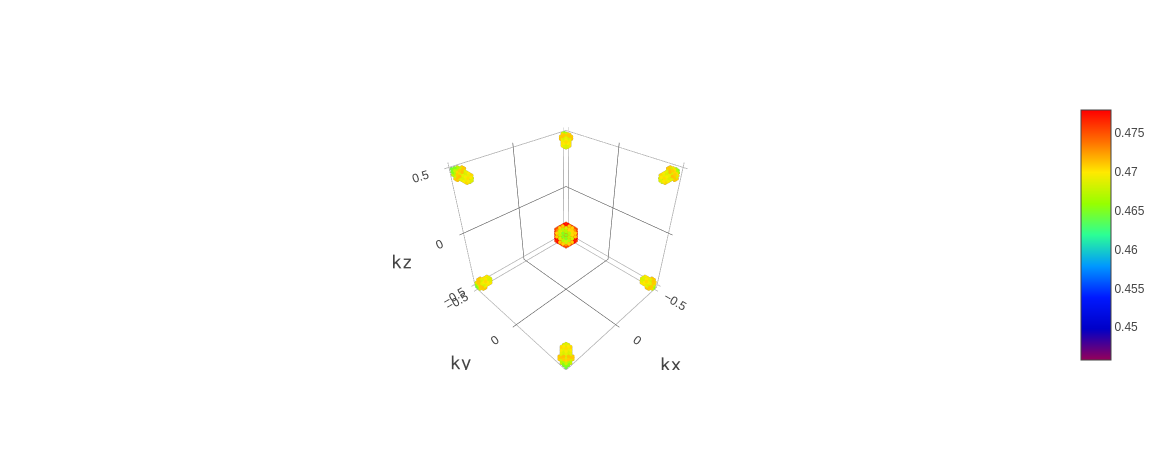

In [11]:
trace1 = go.Scatter3d(
    x=cart_kpts_df['kx [1/A]'].values/(2*np.pi/(a)),
    y=cart_kpts_df['ky [1/A]'].values/(2*np.pi/(a)),
    z=cart_kpts_df['kz [1/A]'].values/(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        color=enk_df['energy [Ryd]'],
        colorscale='Rainbow',
        showscale=True,
        opacity=1
    )
)

trace2 = go.Scatter

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

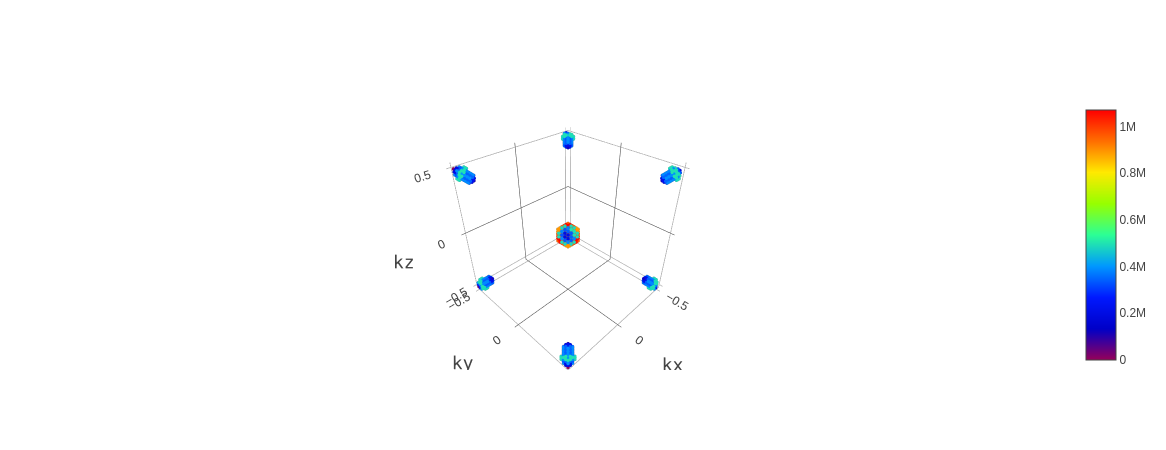

In [12]:
trace1 = go.Scatter3d(
    x=cart_kpts_df['kx [1/A]'].values/(2*np.pi/(a)),
    y=cart_kpts_df['ky [1/A]'].values/(2*np.pi/(a)),
    z=cart_kpts_df['kz [1/A]'].values/(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        color=cart_kpts_df['v_mag [m/s]'],
        colorscale='Rainbow',
        showscale=True,
        opacity=1
    )
)

trace2 = go.Scatter

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

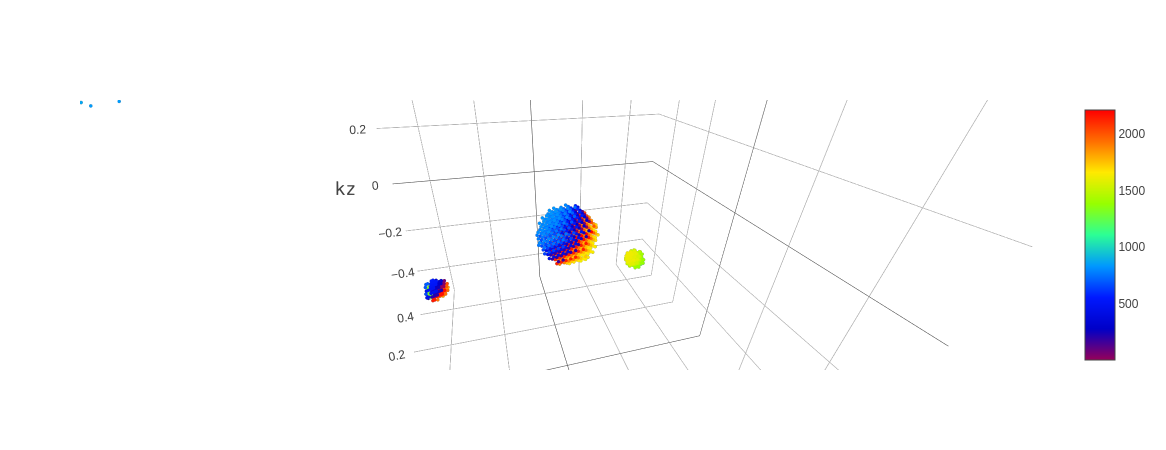

In [13]:
trace1 = go.Scatter3d(
    x=cart_kpts_df['kx [1/A]'].values/(2*np.pi/(a)),
    y=cart_kpts_df['ky [1/A]'].values/(2*np.pi/(a)),
    z=cart_kpts_df['kz [1/A]'].values/(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        color=cart_kpts_df['k_inds'],
        colorscale='Rainbow',
        showscale=True,
        opacity=1
    )
)

trace2 = go.Scatter

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

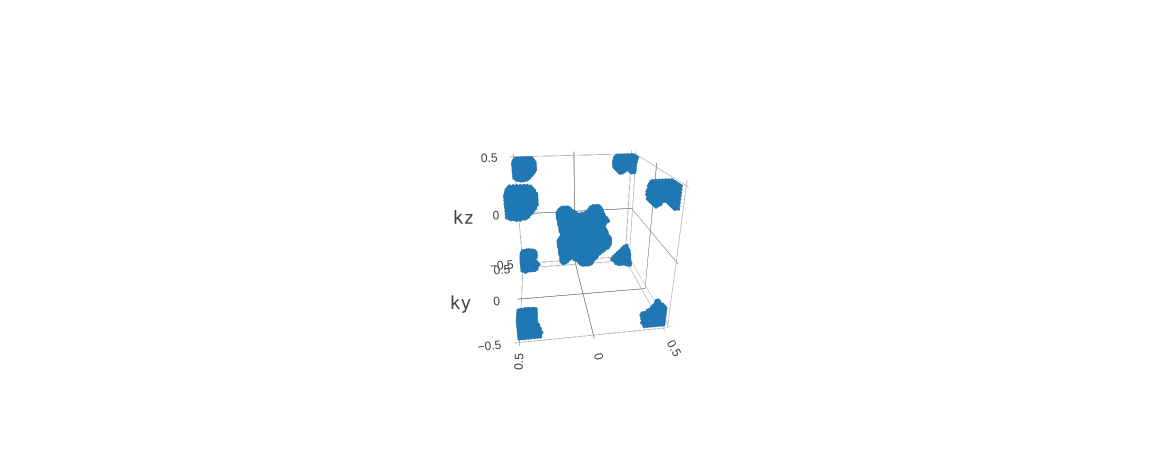

In [14]:
trace1 = go.Scatter3d(
    x=edit_cart_qpts_df['kx [1/A]'].values,
    y=edit_cart_qpts_df['ky [1/A]'].values,
    z=edit_cart_qpts_df['kz [1/A]'].values,
    mode='markers',
    marker=dict(
        size=2,
        opacity=1
    )
)

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [16]:
def fermi_distribution(g_df,mu,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]


    g_df['k_FD'] = (np.exp((g_df['k_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)
    g_df['k+q_FD'] = (np.exp((g_df['k+q_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)

    return g_df

In [17]:
def bose_distribution(g_df,T):
    """
    This function takes a list of q-point indices and returns the Bose-Einstein distributions associated with each q-point on that list.    
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        BE : vector_like, shape (n,1)
        Bose-einstein distribution
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]

    g_df['BE'] = (np.exp((g_df['q_en [eV]'].values*e)/(kb*T)) - 1)**(-1)
    return g_df

In [18]:
def fermionic_processing(g_df,cart_kpts_df,enk_df,mu,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
               
    cart_kpts_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]
        
    enk_df : pandas dataframe containing

        k_inds : vector_like, shape (n,1)
        Index of k point
        
        band_inds : vector_like, shape (n,1)
        Band index
        
        energy [Ryd] : vector_like, shape (n,1)
        Energy associated with k point in Rydberg units
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    index_vector = cart_kpts_df['k_inds'].values    
    g_df['k_en [eV]'] = np.zeros(len(g_df))
    g_df['k+q_en [eV]'] = np.zeros(len(g_df))
    g_df['collision_state'] = np.zeros(len(g_df))
    
    for i1 in trange(len(cart_kpts_df)):
        index = index_vector[i1]
        
        g_slice_k = g_df['k_inds'] == index        
        g_slice_kq = g_df['k+q_inds'] == index
        
        k_slice = cart_kpts_df['k_inds'] == index
        enk_slice = enk_df['k_inds'] == index
        
        g_df.loc[g_slice_k,'k_en [eV]'] = enk_df.loc[enk_slice,'energy [Ryd]'].values*13.6056980659 
        g_df.loc[g_slice_kq,'k+q_en [eV]'] = enk_df.loc[enk_slice,'energy [Ryd]'].values*13.6056980659
        
    abs_inds = g_df['k_en [eV]'] < g_df['k+q_en [eV]'] #absorbed indices
    ems_inds = g_df['k_en [eV]'] > g_df['k+q_en [eV]'] #emission indices
    
    g_df.loc[abs_inds,'collision_state'] = 1
    g_df.loc[ems_inds,'collision_state'] = -1
    
    g_df = fermi_distribution(g_df,mu, T)
    
    return g_df

In [20]:
def bosonic_processing(g_df,enq_df,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
               
    cart_qpts_df : pandas dataframe containing:
    
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]
        
    enq_df : pandas dataframe containing

        k_inds : vector_like, shape (n,1)
        Index of k point
        
        im_mode : vector_like, shape (n,1)
        Phonon polarization index
        
        energy [Ryd] : vector_like, shape (n,1)
        Energy associated with k point in Rydberg units
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    modified_g_df = g_df.copy(deep=True)
    modified_g_df.set_index(['q_inds', 'im_mode'], inplace=True)
    modified_g_df = modified_g_df.sort_index()
    modified_enq_df = enq_df.copy(deep=True)
    modified_enq_df.set_index(['q_inds', 'im_mode'], inplace=True)
    modified_enq_df = modified_enq_df.sort_index()
    modified_enq_df = modified_enq_df.loc[modified_g_df.index.unique()]
    
    modified_enq_df = modified_enq_df.reset_index()
    modified_enq_df = modified_enq_df.sort_values(['q_inds','im_mode'],ascending=True)
    modified_enq_df = modified_enq_df[['q_inds','im_mode','energy [Ryd]']]
    modified_enq_df['q_id'] = modified_enq_df.groupby(['q_inds','im_mode']).ngroup()
    g_df['q_id'] = g_df.sort_values(['q_inds','im_mode'],ascending=True).groupby(['q_inds','im_mode']).ngroup()
    
    g_df['q_en [eV]'] = modified_enq_df['energy [Ryd]'].values[g_df['q_id'].values]*13.6056980659
    
    g_df = bose_distribution(g_df,T)
    
    return g_df,modified_enq_df

In [35]:
g_df.loc[g_df['q_id'] == 1000].head()

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
22032,10,177,79,1,1,2,0.000009,6.330016,6.335456,1.0,5.769632e-10,4.675006e-10,1000,0.008132,2.705461
42663,18,177,192,1,1,2,0.000009,6.330016,6.335456,1.0,5.769632e-10,4.675006e-10,1000,0.008132,2.705461
68143,31,177,203,1,1,2,0.000002,6.356677,6.369760,1.0,2.057405e-10,1.240404e-10,1000,0.008132,2.705461
72638,33,177,86,1,1,2,0.000011,6.373457,6.381889,1.0,1.075115e-10,7.759167e-11,1000,0.008132,2.705461
77378,34,177,87,1,1,2,0.000012,6.361878,6.360348,-1.0,1.682493e-10,1.785036e-10,1000,0.008132,2.705461


In [68]:
g_df.loc[g_df['k_inds'] == 79]

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
216515,79,4,85,1,1,1,1.230576e-13,6.335456,6.322644,-1.0,4.675006e-10,7.673370e-10,13,0.001423,17.678837
216516,79,4,85,1,1,2,4.373684e-08,6.335456,6.322644,-1.0,4.675006e-10,7.673370e-10,14,0.001447,17.373017
216517,79,4,85,1,1,3,6.143211e-06,6.335456,6.322644,-1.0,4.675006e-10,7.673370e-10,15,0.002755,8.894565
216518,79,4,85,1,1,4,6.926078e-07,6.335456,6.322644,-1.0,4.675006e-10,7.673370e-10,16,0.033041,0.386213
216519,79,4,85,1,1,5,6.129793e-15,6.335456,6.322644,-1.0,4.675006e-10,7.673370e-10,17,0.033043,0.386173
216520,79,4,85,1,1,6,5.276435e-04,6.335456,6.322644,-1.0,4.675006e-10,7.673370e-10,18,0.035378,0.341437
216521,79,85,86,1,1,4,4.686579e-08,6.335456,6.381889,1.0,4.675006e-10,7.759167e-11,476,0.033052,0.385991
216522,79,85,86,1,1,5,1.745107e-15,6.335456,6.381889,1.0,4.675006e-10,7.759167e-11,477,0.033058,0.385851
216523,79,85,86,1,1,6,7.637793e-04,6.335456,6.381889,1.0,4.675006e-10,7.759167e-11,478,0.035389,0.341245
216524,79,86,87,1,1,2,6.346663e-06,6.335456,6.360348,1.0,4.675006e-10,1.785036e-10,479,0.001002,25.318508


In [60]:
np.abs(-enk_df.loc[enk_df['k_inds'] == 10]['energy [Ryd]'].values+enk_df.loc[enk_df['k_inds'] == 79]['energy [Ryd]'].values)*13.6056980659

array([0.00543929])

In [61]:
np.abs(-enk_df.loc[enk_df['k_inds'] == 34]['energy [Ryd]'].values+enk_df.loc[enk_df['k_inds'] == 87]['energy [Ryd]'].values)*13.6056980659

array([0.00152962])

In [55]:
enq_df.loc[enq_df['q_inds'] == 177]

,q_inds,im_mode,energy [Ryd]
1056,177,1,0.000590
1057,177,2,0.000598
1058,177,3,0.001821
1059,177,4,0.002168
1060,177,5,0.002339
1061,177,6,0.002345


In [19]:
g_df = fermionic_processing(g_df,cart_kpts_df,enk_df,5.780,300)

100%|██████████████████████████████████████████████████████████████████████████████| 2213/2213 [09:01<00:00,  4.25it/s]


In [21]:
g_df,modified_enq_df = bosonic_processing(g_df,enq_df,T)

In [34]:
modified_enq_df.loc[modified_enq_df['q_id'] == 1000].head()

,q_inds,im_mode,energy [Ryd],q_id
1000,177,2,0.000598,1000


In [62]:
cart_kpts_df.loc[cart_kpts_df['k_inds']==231]

,k_inds,bands,energy,kx [1/A],ky [1/A],kz [1/A],vx_dir,vy_dir,vz_dir,v_mag [m/s]
230,231,1.0,6.328666,0.554133,0.554133,0.554133,-0.41733,-0.80726,-0.41733,200713.144503


In [63]:
cart_kpts_df.loc[cart_kpts_df['k_inds']==1201]

,k_inds,bands,energy,kx [1/A],ky [1/A],kz [1/A],vx_dir,vy_dir,vz_dir,v_mag [m/s]
1200,1201,1.0,6.328666,-0.554133,-0.554133,-0.554133,0.41733,0.41733,0.80726,200713.144503


In [32]:
g_df.loc[g_df['collision_state'] == 0]

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
753102,231,20621,1201,1,1,1,3.169902e-11,6.328666,6.328666,0.0,6.079043e-10,6.079043e-10,119168,0.010299,2.043496
753103,231,20621,1201,1,1,2,6.413786e-07,6.328666,6.328666,0.0,6.079043e-10,6.079043e-10,119169,0.010350,2.031388
753104,231,20621,1201,1,1,3,7.316244e-06,6.328666,6.328666,0.0,6.079043e-10,6.079043e-10,119170,0.027218,0.536080
862639,275,4067,793,1,1,1,2.475741e-09,6.429567,6.429567,0.0,1.227299e-11,1.227299e-11,23479,0.001405,17.901252
862640,275,4067,793,1,1,2,3.916928e-07,6.429567,6.429567,0.0,1.227299e-11,1.227299e-11,23480,0.001464,17.162889
862641,275,4067,793,1,1,3,3.651209e-06,6.429567,6.429567,0.0,1.227299e-11,1.227299e-11,23481,0.002072,11.984090
2343700,671,2518,813,1,1,1,3.311432e-07,6.397796,6.397796,0.0,4.193903e-11,4.193903e-11,14453,0.001045,24.240617
2343701,671,2518,813,1,1,2,3.141311e-06,6.397796,6.397796,0.0,4.193903e-11,4.193903e-11,14454,0.001432,17.564126
2343702,671,2518,813,1,1,3,4.928878e-06,6.397796,6.397796,0.0,4.193903e-11,4.193903e-11,14455,0.002197,11.276051
2860129,835,867,856,1,1,3,6.021424e-06,6.394719,6.394719,0.0,4.723952e-11,4.723952e-11,4916,0.001133,22.322157


In [66]:
np.min(g_df['g_element'].values)

3.0244601986461747e-27

In [22]:
g_df.head()

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
0,1,1,2,1,1,5,6.279619e-20,6.065254,6.093535,1.0,0.000016,0.000005,1,0.033090,0.385195
1,1,1,2,1,1,6,1.016675e-02,6.065254,6.093535,1.0,0.000016,0.000005,2,0.035405,0.340956
2,1,1,26,1,1,4,1.167235e-08,6.065254,6.093535,1.0,0.000016,0.000005,0,0.033090,0.385198
3,1,1,26,1,1,5,3.516638e-20,6.065254,6.093535,1.0,0.000016,0.000005,1,0.033090,0.385195
4,1,1,26,1,1,6,1.016675e-02,6.065254,6.093535,1.0,0.000016,0.000005,2,0.035405,0.340956


In [42]:
g_df['k_en [eV]'] - g_df['k+q_en [eV]']

0         -2.828065e-02
1         -2.828065e-02
2         -2.828065e-02
3         -2.828065e-02
4         -2.828065e-02
5         -2.845990e-02
6         -2.845990e-02
7         -2.845990e-02
8         -3.766978e-02
9         -3.766978e-02
10        -3.766978e-02
11        -2.845990e-02
12        -2.845990e-02
13        -2.845990e-02
14        -3.766978e-02
15        -3.766978e-02
16        -3.766978e-02
17        -2.828065e-02
18        -2.828065e-02
19        -2.828065e-02
20        -3.766978e-02
21        -3.766978e-02
22        -3.766978e-02
23        -3.766978e-02
24        -3.766978e-02
25        -3.766978e-02
26        -2.828065e-02
27        -2.828065e-02
28        -2.828065e-02
29        -1.776357e-15
               ...     
7854578   -4.351143e-02
7854579   -4.351143e-02
7854580   -9.389131e-03
7854581   -9.389131e-03
7854582   -9.389131e-03
7854583   -1.456613e-13
7854584   -9.389131e-03
7854585   -9.389131e-03
7854586   -9.389131e-03
7854587   -9.389131e-03
7854588   -4.309

In [40]:
np.max(g_df['k_en [eV]'])-np.min(g_df['k_en [eV]'])

0.4373955800678173

In [41]:
(np.max(enk_df['energy [Ryd]'])-np.min(enk_df['energy [Ryd]']))*13.6056980659

0.4373955800678173

In [24]:
def scattering_rate(g_df):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    abs_g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    
         
    """
    
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    
    g_df_ems = g_df.loc[(g_df['collision_state'] == -1)].copy(deep=True)
    g_df_abs = g_df.loc[(g_df['collision_state'] == 1)].copy(deep=True)
    
    g_df_ems['weight'] = np.multiply(g_df_ems['BE'].values + 1 - g_df_ems['k+q_FD'].values,g_df_ems['g_element'].values)
    g_df_abs['weight'] = np.multiply(g_df_abs['BE'].values + g_df_abs['k+q_FD'].values,g_df_abs['g_element'].values)

    
    
    
    abs_sr = g_df_abs.groupby(['k_inds'])['weight'].agg('sum')
    abs_scattering = abs_sr.to_frame().reset_index()
    
    ems_sr = g_df_ems.groupby(['k_inds'])['weight'].agg('sum')
    ems_scattering = ems_sr.to_frame().reset_index()
    
    return abs_scattering,ems_scattering

In [25]:
abs_scattering,ems_scattering = scattering_rate(g_df)

In [ ]:
def coupling_matrix_calc(g_df):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    abs_g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    
         
    """
    
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    
    g_df_ems = g_df.loc[(g_df['collision_state'] == -1)].copy(deep=True)
    g_df_abs = g_df.loc[(g_df['collision_state'] == 1)].copy(deep=True)
    
    g_df_ems['weight'] = np.multiply(g_df_ems['BE'].values + 1 - g_df_ems['k+q_FD'].values,g_df_ems['g_element'].values)
    g_df_abs['weight'] = np.multiply(g_df_abs['BE'].values + g_df_abs['k+q_FD'].values,g_df_abs['g_element'].values)

    g_df_abs['id'] = g_df_abs.groupby(['k_inds','k+q_inds']).ngroup()
    g_df_ems['id'] = g_df_ems.groupby(['k_inds','k+q_inds']).ngroup()    
    
    
    
    abs_sr = g_df_abs.groupby(['k_inds', 'k+q_inds','id'])['weight'].agg('sum')
    summed_abs_df = abs_sr.to_frame().reset_index()
    
    ems_sr = g_df_ems.groupby(['k_inds', 'k+q_inds','id'])['weight'].agg('sum')
    summed_ems_df = ems_sr.to_frame().reset_index()
    
    return summed_abs_df,summed_ems_df

In [ ]:
abs_scattering_array = np.zeros(len(np.unique(enk_df['k_inds'])))
ems_scattering_array = np.zeros(len(np.unique(enk_df['k_inds'])))
abs_scattering_array[abs_scattering['k_inds'].values-1] = abs_scattering['weight'].values
ems_scattering_array[ems_scattering['k_inds'].values-1] = ems_scattering['weight'].values

In [ ]:
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 40})
plt.rcParams.update({'lines.linewidth': 3.5})

fig = plt.figure(figsize=(12,10))
ax = plt.gca()

plt.scatter(enk_df['energy [Ryd]'].values,abs_scattering_array+ems_scattering_array,c = 'Red')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Scattering Rate [1/fs]')
plt.xlabel('Energy [Ryd]')
#plt.legend()
plt.show()
fig.savefig('test.png', bbox_inches='tight')

In [ ]:
abs_scattering_array+ems_scattering_array

In [ ]:
summed_abs_df,summed_ems_df = coupling_matrix_calc(g_df)

In [ ]:
interesting_abs = summed_abs_df.groupby(['k_inds'])['weight'].agg('sum').to_frame().reset_index()

In [ ]:
interesting_ems = summed_ems_df.groupby(['k_inds'])['weight'].agg('sum').to_frame().reset_index()

In [ ]:
len(interesting_abs)

In [ ]:
g_df.loc[(g_df['k_inds'] == 2213)* g_df['k+q_inds'] == 502]

In [ ]:
g_df.loc[(g_df['q_inds'] == 4015)*(g_df['collision_state'] == -1)]

In [ ]:
summed_abs_df.loc[summed_abs_df['id'] == 500]

In [ ]:
summed_ems_df.loc[summed_ems_df['id'] == 539]

In [ ]:
summed_ems_df.loc[summed_ems_df['k+q_inds'] == 1019]

In [ ]:
abs_array = np.zeros((len(np.unique(enk_df['k_inds'])),len(np.unique(enk_df['k_inds']))))
ems_array = np.zeros((len(np.unique(enk_df['k_inds'])),len(np.unique(enk_df['k_inds']))))

In [ ]:
abs_array[summed_abs_df['k_inds'].values-1,summed_abs_df['k+q_inds'].values-1] = summed_abs_df['weight'].values
ems_array[summed_ems_df['k_inds'].values-1,summed_ems_df['k+q_inds'].values-1] = summed_ems_df['weight'].values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('inferno')
fig = plt.figure(figsize=(20, 12.2))

ax = fig.add_subplot(111)
ax.set_title('Collision Matrix')
plt.imshow(abs_array/np.max(abs_array))
ax.set_aspect('equal')
plt.xlabel('k index')
plt.ylabel('k_p index')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('Coupling Rate [arb]', rotation=270)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('inferno')

fig = plt.figure(figsize=(20, 12.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(ems_array/np.max(ems_array))
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
plt.imshow(ems_array);
plt.colorbar()
plt.show()

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot
import numpy as np

# make a color map of fixed colors
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['blue','black','red'],
                                           256)

# tell imshow about color map so that only set colors are used
img = pyplot.imshow(ems_array*1000,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower')

pyplot.show()

In [ ]:
np.sum(abs_array+ems_array,axis=1)

In [69]:
import matplotlib as mpl
from matplotlib import pyplot
import numpy as np

# make a color map of fixed colors
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['blue','black','red'],
                                           256)

# tell imshow about color map so that only set colors are used
img = pyplot.imshow(ems_array*1000,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower')

pyplot.show()

NameError: name 'ems_array' is not defined

In [71]:
"hello"

'hello'

## Data validation (Peishi Updated: 4/30)

In [13]:
def plot_bandstructure(kpts, enk): 
    '''Plots electron bandstructure. 
    
    Path is hardcoded for FCC unit cell. Currently just plotting Gamma-L and Gamma-X 
    
    Parameters: 
    ------------ 
    kpts : dataframe containing 
        k_inds : vector_like, shape (n,1) 
        Index of k point 

        'kx [1/A]' : vector_like, shape (n,1) 
        x-coordinate in Cartesian momentum space     

        'ky [1/A]' : vector_like, shape (n,1) 
        y-coordinate in Cartesian momentum space 

        'kz [1/A]' : vector_like, shape (n,1) 
        z-coordinate in Cartesian momentum space 

    enk : dataframe containing 
        k_inds : vector_like, shape (n,1) 
        Index of k point 

        band_inds : vector_like, shape (n,1) 
        Band index 

        energy [Ryd] : vector_like, shape (n,1) 
        Energy associated with k point in Rydberg units 

    Returns: 
    --------- 
    No variable returns. Just plots the dispersion  
    '''
    
    # Lattice constant and reciprocal lattice vectors 
    # b1 = 2 pi/a (kx - ky + kz) 
    # b2 = 2 pi/a (kx + ky - kz) 
    # b3 = 2 pi/a (-kx + ky + kz) 
    a = 5.556 #[A] 
    b1 = (2*np.pi/a) * np.array([1, -1, 1]) 
    b2 = (2*np.pi/a) * np.array([1, 1, -1]) 
    b3 = (2*np.pi/a) * np.array([-1, 1, 1]) 

    # L point in BZ is given by 0.5*b1 + 0.5*b2 + 0.5*b3 
    # X point in BZ is given by 0.5*b2 + 0.5*b3 
    lpoint = 0.5 * (b1 + b2 + b3) 
    xpoint = 0.5 * (b2 + b3) 

    # We can find kpoints along a path just by considering a dot product with lpoint and xpoint vectors. 
    # Any kpoints with angle smaller than some tolerance are considered on the path and we can plot their corresponding frequencies 
    deg2rad = 2*np.pi/360 
    ang_tol = 1 * deg2rad  # 1 degree in radians 

    enkonly = np.array(enk['energy [Ryd]'])[:, np.newaxis] 
    kptsonly = np.array(kpts[['kx [1/A]', 'ky [1/A]', 'kz [1/A]']]) / (2*np.pi/a) 
    kptsmag = np.linalg.norm(kptsonly, axis=1)[:, np.newaxis] 

    dot_l = np.zeros(len(kpts))
    dot_x = np.zeros(len(kpts))

    # Separate assignment for gamma point to avoid divide by zero error
    nongamma = kptsmag!=0
    dot_l[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, lpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(lpoint) 
    dot_x[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, xpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(xpoint) 
    dot_l[np.squeeze(kptsmag==0)] = 0 
    dot_x[np.squeeze(kptsmag==0)] = 0 

    lpath = np.logical_or(np.arccos(dot_l) < ang_tol, np.squeeze(kptsmag == 0))
    xpath = np.logical_or(np.arccos(dot_x) < ang_tol, np.squeeze(kptsmag == 0))

    plt.figure() 
    plt.plot(kptsmag[lpath], enkonly[lpath], '.') 
    plt.plot(-1*kptsmag[xpath], enkonly[xpath], '.') 
    plt.xlabel('k magnitude') 
    plt.ylabel('Energy in Ry')
    plt.show()

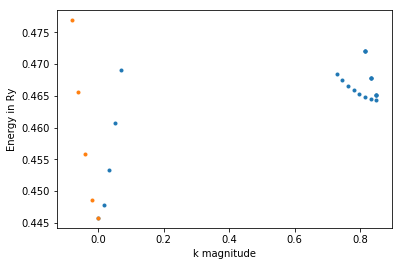

In [14]:
plot_bandstructure(cart_kpts_df, enk_df)

(21080, 3)
(21080, 1)
(21080, 6)


/home/peishi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in arccos

/home/peishi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in less



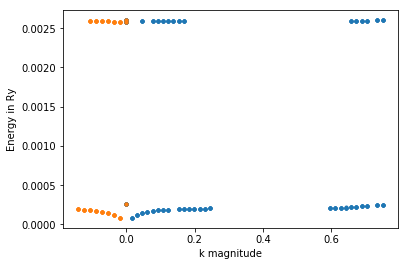

In [15]:
# plot_bandstructure(edit_cart_qpts_df, enq_df)
kpts = cart_kpts_df
enk = enk_df

kpts = edit_cart_qpts_df
enk = enq_df

a = 5.556 #[A] 
b1 = (2*np.pi/a) * np.array([1, -1, 1]) 
b2 = (2*np.pi/a) * np.array([1, 1, -1]) 
b3 = (2*np.pi/a) * np.array([-1, 1, 1]) 

# L point in BZ is given by 0.5*b1 + 0.5*b2 + 0.5*b3 
# X point in BZ is given by 0.5*b2 + 0.5*b3 
lpoint = 0.5 * (b1 + b2 + b3) 
xpoint = 0.5 * (b2 + b3) 

# We can find kpoints along a path just by considering a dot product with lpoint and xpoint vectors. 
# Any kpoints with angle smaller than some tolerance are considered on the path and we can plot their corresponding frequencies 
deg2rad = 2*np.pi/360 
ang_tol = 1 * deg2rad  # 1 degree in radians 

kptsonly = np.array(kpts[['kx [1/A]', 'ky [1/A]', 'kz [1/A]']]) / (2*np.pi/a) 
kptsmag = np.linalg.norm(kptsonly, axis=1)[:, np.newaxis] 

print(kptsonly.shape)
print(kptsmag.shape)

dot_l = np.zeros(len(kpts))
dot_x = np.zeros(len(kpts))

# Separate assignment for gamma point to avoid divide by zero error
nongamma = kptsmag!=0
dot_l[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, lpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(lpoint) 
dot_x[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, xpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(xpoint) 
dot_l[np.squeeze(kptsmag==0)] = 0 
dot_x[np.squeeze(kptsmag==0)] = 0 

lpath = np.logical_or(np.arccos(dot_l) < ang_tol, np.squeeze(kptsmag == 0))
xpath = np.logical_or(np.arccos(dot_x) < ang_tol, np.squeeze(kptsmag == 0))

# Need to reshape the energy dataframe for easy plotting if there are multiple bands
enk_ra = np.array(enk.iloc[:,:])
enk_ra.sort(axis=0)
nk = int(np.max(enk_ra[:, 0]))  # nk = number of kpts = highest kpts index
if np.mod(len(enk_ra), nk) != 0:
    exit('Something is wack with the number of bands and kpoints in the array')
else:
    nb = int(len(enk_ra) / nk)
enkonly = enk_ra[:, 2]
enk_by_band = np.reshape(enkonly, (nk, nb), order='C')

print(enk_by_band.shape)

plt.figure()
for b in range(nb):
    plt.plot(kptsmag[lpath], enk_by_band[lpath, b], '.', color='C0') 
    plt.plot(-1*kptsmag[xpath], enk_by_band[xpath, b], '.', color='C1') 
plt.xlabel('k magnitude') 
plt.ylabel('Energy in Ry')
plt.show()